In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
import torch
from torchvision import transforms
dtype = torch.float

In [4]:
device = torch.device("cuda")

## Image

In [37]:
IM = Path('data/rando/obama.jpeg')

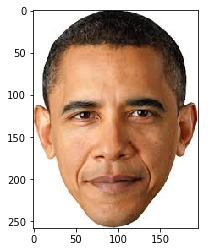

In [38]:
img = open_image(IM)
plt.imshow(img);

In [39]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()

In [40]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
# don't waste time/memory calculating gradients

### features

In [41]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [16]:
# find conv layers after pool layers -> used in the paper
block_ends = [i+1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends.pop()
block_ends

[7, 14, 24, 34]

### Fastai transforms

In [42]:
_, val_tfms = tfms_from_model(vgg16, 288)

In [43]:
img_tfm = val_tfms(img)

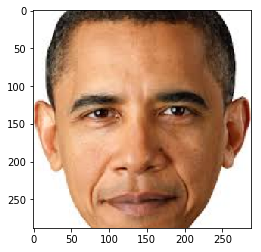

In [44]:
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)))

## Style

In [45]:
STYLE = Path('data/rando/hawaii_scene.jpeg')
style_img = open_image(STYLE)
style_img.shape, img.shape

((181, 279, 3), (258, 195, 3))

In [46]:
# resize style image to be same size as target image
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw)
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [47]:
style = scale_match(img, style_img)
style.shape

(258, 195, 3)

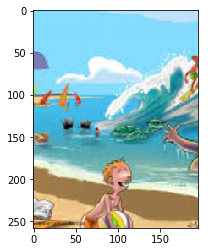

In [48]:
plt.imshow(style);

In [49]:
# save features for all block_ends -> array of activation layers
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [50]:
style_tfm = val_tfms(style)

In [51]:
m_vgg(V(style_tfm[None]))
targ_styles = [sf.features.clone() for sf in sfs]
[s.shape for s in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [52]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1) # flatten batch (1) and channel, height X width
        return torch.mm(x, x.t())/input.numel()*1e6
    
        #np.square(input.numel())*4  -> normalizer to mse used in the paper...
        
        # matrix multiply w/ transpose
        # normalize by dividing by number of elements (b*c*h*w)
        # results in a tiny number so we multiply by a big number (1e6) to make it more sensible

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

## Style Transfer

In [53]:
# duplicated input image instead of noise

opt_img_v = V(img_tfm.copy()[None], requires_grad=True)
optimizer = optim.LBFGS([opt_img_v])

In [54]:
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [55]:
def step(loss_fn, mult):
    global n_iter
    optimizer.zero_grad()
    loss, content, style = loss_fn(opt_img_v, mult)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0:
        print(f'Iteration: {n_iter}, loss: {loss.item()}, content: {content.item()}, style: {style.item()}')
    return loss

In [56]:
def comb_loss(x, mult):
    # 1e5 => 168.55975341796875
    # 1e6 => 648.6123657226562
    # 1e7 => 2057.2021484375
    m_vgg(opt_img_v)
    outs = [sf.features for sf in sfs]
    style_losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    content_loss = F.mse_loss(outs[3], targ_vs[3])
    
    style = sum(style_losses)
    content = content_loss * mult
    return (style+content), content, style            # losses added together w/ multiplier

In [ ]:
max_iter = 1000
show_iter = 100

n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss,1e6))

Iteration: 100, loss: 678.9869384765625, content: 512.5383911132812, style: 166.44854736328125
Iteration: 200, loss: 647.342041015625, content: 488.1997985839844, style: 159.1422119140625
Iteration: 300, loss: 619.5641479492188, content: 467.431396484375, style: 152.13275146484375
Iteration: 400, loss: 594.977294921875, content: 448.7560119628906, style: 146.22128295898438
Iteration: 500, loss: 572.6207885742188, content: 431.702880859375, style: 140.9178924560547
Iteration: 600, loss: 553.8457641601562, content: 417.6653747558594, style: 136.1803741455078
Iteration: 700, loss: 536.4738159179688, content: 404.82269287109375, style: 131.651123046875


#### 1e5

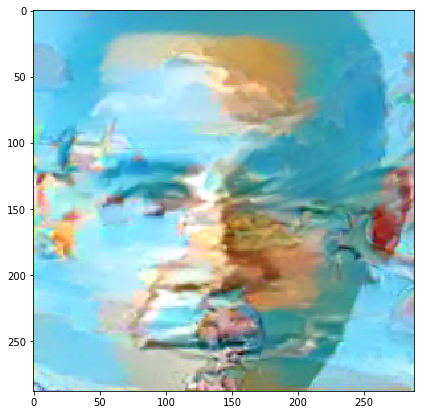

In [58]:
#=> 135.58486938476562
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### 1e6

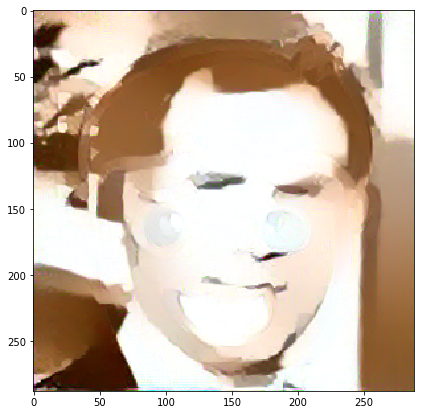

In [57]:
#=> 442.21685791015625
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);

#### Conv3-1

In [26]:
max_iter = 1000
show_iter = 100

n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 0, loss: 2252082.5
Iteration: 100, loss: 2183.73681640625
Iteration: 200, loss: 526.4005126953125
Iteration: 300, loss: 363.7401428222656
Iteration: 400, loss: 314.3968200683594
Iteration: 500, loss: 293.0018310546875
Iteration: 600, loss: 280.61572265625
Iteration: 700, loss: 272.6527404785156
Iteration: 800, loss: 267.1320495605469
Iteration: 900, loss: 263.0524597167969
Iteration: 1000, loss: 259.88140869140625


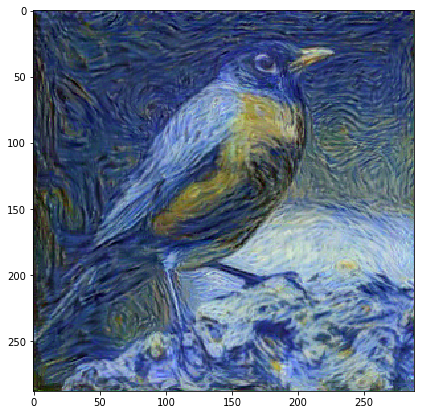

In [27]:
#=> 11.658407211303711
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
x=np.clip(x,0,1)
plt.figure(figsize=(7,7))
plt.imshow(x, interpolation='lanczos')
plt.imshow(x);